In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.0724 - STD: 1.3555e-04 - MAE: 0.2592

 4/64 [>.............................] - ETA: 13s - loss: 0.0352 - STD: 3.1071e-04 - MAE: 0.1399 

 7/64 [==>...........................] - ETA: 7s - loss: 0.0334 - STD: 2.4422e-04 - MAE: 0.1391 

 8/64 [==>...........................] - ETA: 6s - loss: 0.0324 - STD: 2.3142e-04 - MAE: 0.1365

 9/64 [===>..........................] - ETA: 6s - loss: 0.0311 - STD: 2.2322e-04 - MAE: 0.1321

10/64 [===>..........................] - ETA: 5s - loss: 0.0296 - STD: 2.1883e-04 - MAE: 0.1264

11/64 [====>.........................] - ETA: 5s - loss: 0.0281 - STD: 2.1725e-04 - MAE: 0.1204

12/64 [====>.........................] - ETA: 5s - loss: 0.0267 - STD: 2.1749e-04 - MAE: 0.1165

13/64 [=====>........................] - ETA: 4s - loss: 0.0257 - STD: 2.1878e-04 - MAE: 0.1146

14/64 [=====>........................] - ETA: 4s - loss: 0.0249 - STD: 2.2073e-04 - MAE: 0.1143

15/64 [======>.......................] - ETA: 4s - loss: 0.0244 - STD: 2.2283e-04 - MAE: 0.1147

16/64 [======>.......................] - ETA: 4s - loss: 0.0240 - STD: 2.2502e-04 - MAE: 0.1150

17/64 [======>.......................] - ETA: 4s - loss: 0.0236 - STD: 2.2737e-04 - MAE: 0.1149

18/64 [=======>......................] - ETA: 4s - loss: 0.0231 - STD: 2.2963e-04 - MAE: 0.1140

19/64 [=======>......................] - ETA: 3s - loss: 0.0225 - STD: 2.3153e-04 - MAE: 0.1125

20/64 [========>.....................] - ETA: 3s - loss: 0.0220 - STD: 2.3329e-04 - MAE: 0.1105

21/64 [========>.....................] - ETA: 3s - loss: 0.0216 - STD: 2.3468e-04 - MAE: 0.1083

22/64 [=========>....................] - ETA: 3s - loss: 0.0212 - STD: 2.3592e-04 - MAE: 0.1061

23/64 [=========>....................] - ETA: 3s - loss: 0.0209 - STD: 2.3698e-04 - MAE: 0.1041

24/64 [==========>...................] - ETA: 3s - loss: 0.0207 - STD: 2.3812e-04 - MAE: 0.1023

25/64 [==========>...................] - ETA: 3s - loss: 0.0204 - STD: 2.3946e-04 - MAE: 0.1007

26/64 [===========>..................] - ETA: 3s - loss: 0.0202 - STD: 2.4109e-04 - MAE: 0.0992

27/64 [===========>..................] - ETA: 2s - loss: 0.0199 - STD: 2.4311e-04 - MAE: 0.0977

28/64 [============>.................] - ETA: 2s - loss: 0.0197 - STD: 2.4567e-04 - MAE: 0.0964

29/64 [============>.................] - ETA: 2s - loss: 0.0194 - STD: 2.4867e-04 - MAE: 0.0952

30/64 [=============>................] - ETA: 2s - loss: 0.0192 - STD: 2.5213e-04 - MAE: 0.0942

31/64 [=============>................] - ETA: 2s - loss: 0.0190 - STD: 2.5612e-04 - MAE: 0.0935

32/64 [==============>...............] - ETA: 2s - loss: 0.0188 - STD: 2.6038e-04 - MAE: 0.0930

33/64 [==============>...............] - ETA: 2s - loss: 0.0186 - STD: 2.6503e-04 - MAE: 0.0927

34/64 [==============>...............] - ETA: 2s - loss: 0.0184 - STD: 2.6976e-04 - MAE: 0.0925

35/64 [===============>..............] - ETA: 2s - loss: 0.0183 - STD: 2.7485e-04 - MAE: 0.0923

36/64 [===============>..............] - ETA: 2s - loss: 0.0181 - STD: 2.8008e-04 - MAE: 0.0921

37/64 [================>.............] - ETA: 2s - loss: 0.0180 - STD: 2.8529e-04 - MAE: 0.0918

38/64 [================>.............] - ETA: 1s - loss: 0.0178 - STD: 2.9044e-04 - MAE: 0.0914

39/64 [=================>............] - ETA: 1s - loss: 0.0177 - STD: 2.9544e-04 - MAE: 0.0909

40/64 [=================>............] - ETA: 1s - loss: 0.0176 - STD: 3.0051e-04 - MAE: 0.0903

41/64 [==================>...........] - ETA: 1s - loss: 0.0174 - STD: 3.0562e-04 - MAE: 0.0897

42/64 [==================>...........] - ETA: 1s - loss: 0.0173 - STD: 3.1083e-04 - MAE: 0.0891

43/64 [===================>..........] - ETA: 1s - loss: 0.0172 - STD: 3.1609e-04 - MAE: 0.0885

44/64 [===================>..........] - ETA: 1s - loss: 0.0171 - STD: 3.2154e-04 - MAE: 0.0879

45/64 [====================>.........] - ETA: 1s - loss: 0.0171 - STD: 3.2738e-04 - MAE: 0.0874

46/64 [====================>.........] - ETA: 1s - loss: 0.0169 - STD: 3.3338e-04 - MAE: 0.0868

47/64 [=====================>........] - ETA: 1s - loss: 0.0169 - STD: 3.3979e-04 - MAE: 0.0864

48/64 [=====================>........] - ETA: 1s - loss: 0.0168 - STD: 3.4639e-04 - MAE: 0.0859

49/64 [=====================>........] - ETA: 1s - loss: 0.0167 - STD: 3.5347e-04 - MAE: 0.0856

50/64 [======================>.......] - ETA: 1s - loss: 0.0166 - STD: 3.6074e-04 - MAE: 0.0853

51/64 [======================>.......] - ETA: 0s - loss: 0.0165 - STD: 3.6873e-04 - MAE: 0.0851

52/64 [=======================>......] - ETA: 0s - loss: 0.0164 - STD: 3.7697e-04 - MAE: 0.0849

53/64 [=======================>......] - ETA: 0s - loss: 0.0163 - STD: 3.8564e-04 - MAE: 0.0847

54/64 [========================>.....] - ETA: 0s - loss: 0.0163 - STD: 3.9464e-04 - MAE: 0.0845

55/64 [========================>.....] - ETA: 0s - loss: 0.0162 - STD: 4.0393e-04 - MAE: 0.0843

56/64 [=========================>....] - ETA: 0s - loss: 0.0161 - STD: 4.1332e-04 - MAE: 0.0841

57/64 [=========================>....] - ETA: 0s - loss: 0.0161 - STD: 4.2308e-04 - MAE: 0.0839

58/64 [==========================>...] - ETA: 0s - loss: 0.0160 - STD: 4.3324e-04 - MAE: 0.0837

59/64 [==========================>...] - ETA: 0s - loss: 0.0160 - STD: 4.4377e-04 - MAE: 0.0834

60/64 [===========================>..] - ETA: 0s - loss: 0.0159 - STD: 4.5458e-04 - MAE: 0.0832

61/64 [===========================>..] - ETA: 0s - loss: 0.0159 - STD: 4.6580e-04 - MAE: 0.0829

62/64 [============================>.] - ETA: 0s - loss: 0.0158 - STD: 4.7764e-04 - MAE: 0.0827

63/64 [============================>.] - ETA: 0s - loss: 0.0158 - STD: 4.9000e-04 - MAE: 0.0824

64/64 [==============================] - ETA: 0s - loss: 0.0157 - STD: 5.0280e-04 - MAE: 0.0822

64/64 [==============================] - 7s 83ms/step - loss: 0.0157 - STD: 5.0280e-04 - MAE: 0.0822 - val_loss: 0.0166 - val_STD: 0.0010 - val_MAE: 0.0776


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0123 - STD: 0.0014 - MAE: 0.0681

 2/64 [..............................] - ETA: 4s - loss: 0.0126 - STD: 0.0014 - MAE: 0.0692

 3/64 [>.............................] - ETA: 4s - loss: 0.0126 - STD: 0.0015 - MAE: 0.0696

 4/64 [>.............................] - ETA: 4s - loss: 0.0126 - STD: 0.0015 - MAE: 0.0701

 5/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 0.0015 - MAE: 0.0705

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 0.0016 - MAE: 0.0707

 7/64 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 0.0016 - MAE: 0.0710

 8/64 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 0.0017 - MAE: 0.0710

 9/64 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 0.0017 - MAE: 0.0710

10/64 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 0.0018 - MAE: 0.0709

11/64 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 0.0018 - MAE: 0.0708

12/64 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 0.0019 - MAE: 0.0706

13/64 [=====>........................] - ETA: 3s - loss: 0.0126 - STD: 0.0019 - MAE: 0.0704

14/64 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 0.0020 - MAE: 0.0702

15/64 [======>.......................] - ETA: 3s - loss: 0.0125 - STD: 0.0021 - MAE: 0.0700

16/64 [======>.......................] - ETA: 3s - loss: 0.0125 - STD: 0.0021 - MAE: 0.0698

17/64 [======>.......................] - ETA: 3s - loss: 0.0125 - STD: 0.0022 - MAE: 0.0696

18/64 [=======>......................] - ETA: 3s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0695

19/64 [=======>......................] - ETA: 3s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0695

20/64 [========>.....................] - ETA: 2s - loss: 0.0124 - STD: 0.0024 - MAE: 0.0694

21/64 [========>.....................] - ETA: 2s - loss: 0.0124 - STD: 0.0025 - MAE: 0.0693

22/64 [=========>....................] - ETA: 2s - loss: 0.0124 - STD: 0.0026 - MAE: 0.0693

23/64 [=========>....................] - ETA: 2s - loss: 0.0124 - STD: 0.0027 - MAE: 0.0693

24/64 [==========>...................] - ETA: 2s - loss: 0.0123 - STD: 0.0028 - MAE: 0.0693

25/64 [==========>...................] - ETA: 2s - loss: 0.0123 - STD: 0.0030 - MAE: 0.0693

26/64 [===========>..................] - ETA: 2s - loss: 0.0123 - STD: 0.0031 - MAE: 0.0692

27/64 [===========>..................] - ETA: 2s - loss: 0.0123 - STD: 0.0032 - MAE: 0.0692

28/64 [============>.................] - ETA: 2s - loss: 0.0123 - STD: 0.0033 - MAE: 0.0691

29/64 [============>.................] - ETA: 2s - loss: 0.0123 - STD: 0.0035 - MAE: 0.0691

30/64 [=============>................] - ETA: 2s - loss: 0.0122 - STD: 0.0037 - MAE: 0.0689

31/64 [=============>................] - ETA: 2s - loss: 0.0122 - STD: 0.0038 - MAE: 0.0688

32/64 [==============>...............] - ETA: 2s - loss: 0.0122 - STD: 0.0040 - MAE: 0.0688

33/64 [==============>...............] - ETA: 2s - loss: 0.0121 - STD: 0.0042 - MAE: 0.0687

34/64 [==============>...............] - ETA: 2s - loss: 0.0121 - STD: 0.0044 - MAE: 0.0685

35/64 [===============>..............] - ETA: 1s - loss: 0.0121 - STD: 0.0047 - MAE: 0.0684

36/64 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 0.0049 - MAE: 0.0683

37/64 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 0.0052 - MAE: 0.0682

39/64 [=================>............] - ETA: 1s - loss: 0.0120 - STD: 0.0058 - MAE: 0.0679

40/64 [=================>............] - ETA: 1s - loss: 0.0119 - STD: 0.0062 - MAE: 0.0678

41/64 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 0.0065 - MAE: 0.0676

42/64 [==================>...........] - ETA: 1s - loss: 0.0118 - STD: 0.0069 - MAE: 0.0675

43/64 [===================>..........] - ETA: 1s - loss: 0.0117 - STD: 0.0074 - MAE: 0.0673

44/64 [===================>..........] - ETA: 1s - loss: 0.0117 - STD: 0.0079 - MAE: 0.0671

45/64 [====================>.........] - ETA: 1s - loss: 0.0116 - STD: 0.0084 - MAE: 0.0669

46/64 [====================>.........] - ETA: 1s - loss: 0.0116 - STD: 0.0089 - MAE: 0.0667

47/64 [=====================>........] - ETA: 1s - loss: 0.0115 - STD: 0.0095 - MAE: 0.0665

48/64 [=====================>........] - ETA: 1s - loss: 0.0114 - STD: 0.0101 - MAE: 0.0662

49/64 [=====================>........] - ETA: 0s - loss: 0.0113 - STD: 0.0107 - MAE: 0.0659

50/64 [======================>.......] - ETA: 0s - loss: 0.0113 - STD: 0.0114 - MAE: 0.0657

51/64 [======================>.......] - ETA: 0s - loss: 0.0112 - STD: 0.0122 - MAE: 0.0654

52/64 [=======================>......] - ETA: 0s - loss: 0.0111 - STD: 0.0129 - MAE: 0.0651

53/64 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 0.0137 - MAE: 0.0648

54/64 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 0.0146 - MAE: 0.0645

55/64 [========================>.....] - ETA: 0s - loss: 0.0108 - STD: 0.0154 - MAE: 0.0642

56/64 [=========================>....] - ETA: 0s - loss: 0.0107 - STD: 0.0163 - MAE: 0.0639

57/64 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 0.0172 - MAE: 0.0636

58/64 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 0.0181 - MAE: 0.0633

59/64 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 0.0190 - MAE: 0.0630

60/64 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 0.0199 - MAE: 0.0627

61/64 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 0.0209 - MAE: 0.0624

62/64 [============================>.] - ETA: 0s - loss: 0.0102 - STD: 0.0218 - MAE: 0.0621

63/64 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.0227 - MAE: 0.0618

64/64 [==============================] - ETA: 0s - loss: 0.0100 - STD: 0.0236 - MAE: 0.0615

64/64 [==============================] - 4s 70ms/step - loss: 0.0100 - STD: 0.0236 - MAE: 0.0615 - val_loss: 0.0061 - val_STD: 0.0602 - val_MAE: 0.0479


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0836 - MAE: 0.0416

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0417

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0843 - MAE: 0.0411

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0410

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0857 - MAE: 0.0411

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0869 - MAE: 0.0409

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0877 - MAE: 0.0409

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0405

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0883 - MAE: 0.0404

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0889 - MAE: 0.0403

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0894 - MAE: 0.0402

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0898 - MAE: 0.0401

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0899 - MAE: 0.0399

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0902 - MAE: 0.0398

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0907 - MAE: 0.0397

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0913 - MAE: 0.0395

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0913 - MAE: 0.0394

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0914 - MAE: 0.0393

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0917 - MAE: 0.0392

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0920 - MAE: 0.0391

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0923 - MAE: 0.0390

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0924 - MAE: 0.0389

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0924 - MAE: 0.0387

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0927 - MAE: 0.0386

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0929 - MAE: 0.0385

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0931 - MAE: 0.0384

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0932 - MAE: 0.0383

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0933 - MAE: 0.0382

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0934 - MAE: 0.0382

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0935 - MAE: 0.0380

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0936 - MAE: 0.0380

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0937 - MAE: 0.0379

33/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0939 - MAE: 0.0378

34/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0940 - MAE: 0.0377

36/64 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0942 - MAE: 0.0375

37/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0942 - MAE: 0.0374

38/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0944 - MAE: 0.0374

39/64 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0946 - MAE: 0.0373

40/64 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0948 - MAE: 0.0372

41/64 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0948 - MAE: 0.0371

42/64 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0950 - MAE: 0.0371

43/64 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0952 - MAE: 0.0370

44/64 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0954 - MAE: 0.0370

45/64 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0954 - MAE: 0.0369

46/64 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0953 - MAE: 0.0368

47/64 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0955 - MAE: 0.0368

48/64 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0957 - MAE: 0.0367

49/64 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0958 - MAE: 0.0366

50/64 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0958 - MAE: 0.0366

51/64 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0958 - MAE: 0.0365

52/64 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0960 - MAE: 0.0365

53/64 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0961 - MAE: 0.0364

54/64 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0962 - MAE: 0.0364

55/64 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0961 - MAE: 0.0363

56/64 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0961 - MAE: 0.0362

57/64 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0963 - MAE: 0.0362

58/64 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0964 - MAE: 0.0362

59/64 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0964 - MAE: 0.0361

60/64 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0964 - MAE: 0.0361

61/64 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0965 - MAE: 0.0360

62/64 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0967 - MAE: 0.0360

63/64 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0968 - MAE: 0.0359

64/64 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0968 - MAE: 0.0359

64/64 [==============================] - 5s 70ms/step - loss: 0.0030 - STD: 0.0968 - MAE: 0.0359 - val_loss: 0.0029 - val_STD: 0.0784 - val_MAE: 0.0357


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0328

 2/64 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0326

 3/64 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0326

 4/64 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0994 - MAE: 0.0327

 5/64 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0994 - MAE: 0.0327

 6/64 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0994 - MAE: 0.0327

 7/64 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0326

 8/64 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1003 - MAE: 0.0325

 9/64 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0325

10/64 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0325

11/64 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0325

12/64 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0325

13/64 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0324

14/64 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0324

15/64 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0323

16/64 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0323

17/64 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0322

18/64 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0322

19/64 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0322

20/64 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0321

21/64 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0321

22/64 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0321

23/64 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0321

24/64 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0320

25/64 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0320

26/64 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0320

27/64 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0320

28/64 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0320

29/64 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0320

30/64 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0319

31/64 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0319

32/64 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1012 - MAE: 0.0319

33/64 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0319

34/64 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0319

35/64 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

36/64 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0318

37/64 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0318

38/64 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

39/64 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

40/64 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0317

41/64 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0317

43/64 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0317

44/64 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0317

45/64 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0317

46/64 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0316

47/64 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0316

48/64 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0316

49/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0316

50/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0316

51/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0316

52/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0315

53/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0315

54/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0315

55/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0315

56/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0315

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0315

58/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0315

59/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0314

60/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0314

61/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0314

62/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0314

63/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0314

64/64 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0314

64/64 [==============================] - 4s 69ms/step - loss: 0.0022 - STD: 0.1018 - MAE: 0.0314 - val_loss: 0.0025 - val_STD: 0.0870 - val_MAE: 0.0331


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0301

 2/64 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

 3/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0306

 4/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0306

 5/64 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0306

 6/64 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0306

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0306

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0305

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0305

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0305

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0305

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0304

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0305

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

17/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0305

18/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

19/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

20/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0304

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

32/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

33/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0304

34/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

35/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

36/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0304

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

42/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0303

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0303

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

46/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

47/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0303

48/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0303

49/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0303

50/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0303

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0303

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

59/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

61/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

63/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

64/64 [==============================] - 4s 68ms/step - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303 - val_loss: 0.0024 - val_STD: 0.0867 - val_MAE: 0.0324


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0298

 2/64 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1062 - MAE: 0.0308

 3/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 4/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0304

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0304

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0304

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0303

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0302

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0302

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301

16/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0301

17/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0301

18/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0300

19/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300

20/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0300

21/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0301

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0300

23/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0300

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0299

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0299

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0299

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0299

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0299

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

33/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0298

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0298

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0298

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0298

38/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

49/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0296

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0296

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0296

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0296

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

64/64 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295 - val_loss: 0.0024 - val_STD: 0.0922 - val_MAE: 0.0318


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0295

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0292

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0291

 4/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0292

 5/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0291

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0291

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0291

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0291

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0291

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0291

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

19/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

20/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0291

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

34/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

49/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

64/64 [==============================] - 4s 70ms/step - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288 - val_loss: 0.0023 - val_STD: 0.0928 - val_MAE: 0.0312


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0284

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0284

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0286

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0285

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

16/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0285

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

64/64 [==============================] - 4s 68ms/step - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.0908 - val_MAE: 0.0308


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0279

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0284

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0283

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0286

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0286

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

64/64 [==============================] - 4s 70ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0917 - val_MAE: 0.0302


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0278

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0277

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0276

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

64/64 [==============================] - 4s 69ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282 - val_loss: 0.0025 - val_STD: 0.0968 - val_MAE: 0.0319


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0288

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0284

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0278

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0279

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0280

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0277

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0277

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

64/64 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276 - val_loss: 0.0021 - val_STD: 0.0938 - val_MAE: 0.0298


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0269

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0267

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0268

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0268

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0269

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0270

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

64/64 [==============================] - 4s 67ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273 - val_loss: 0.0022 - val_STD: 0.0955 - val_MAE: 0.0301


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1102 - MAE: 0.0274

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0273

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0274

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270 - val_loss: 0.0021 - val_STD: 0.0955 - val_MAE: 0.0298


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0271

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0270

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0269

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0269

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

64/64 [==============================] - 4s 67ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269 - val_loss: 0.0020 - val_STD: 0.0953 - val_MAE: 0.0293


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0265

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0266

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0272

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0285

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0287

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0285

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0290

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0288

17/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

18/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0288

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0287

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0287

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0286

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0286

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0286

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0285

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0286

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0285

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0285

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0285

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0284

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0284

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0284

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0283

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0283

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277 - val_loss: 0.0020 - val_STD: 0.0943 - val_MAE: 0.0290


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0267

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269 - val_loss: 0.0019 - val_STD: 0.0935 - val_MAE: 0.0290


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0266

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

64/64 [==============================] - 4s 70ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0946 - val_MAE: 0.0288


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0263

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0942 - val_MAE: 0.0288


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264 - val_loss: 0.0021 - val_STD: 0.0978 - val_MAE: 0.0296


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1090 - MAE: 0.0271

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0271

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0272

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0268

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263 - val_loss: 0.0019 - val_STD: 0.0918 - val_MAE: 0.0294


Epoch 21/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0275

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0270

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0266

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0269

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0934 - val_MAE: 0.0283


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0263

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0261

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0258

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0269

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.0979 - val_MAE: 0.0288


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0263

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0261

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0261

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0259

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260 - val_loss: 0.0020 - val_STD: 0.0961 - val_MAE: 0.0290


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0950 - val_MAE: 0.0282


Epoch 25/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0255

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0266

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - 4s 67ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0020 - val_STD: 0.0977 - val_MAE: 0.0288


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0253

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0255

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0257

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0256

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

64/64 [==============================] - 4s 63ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0939 - val_MAE: 0.0283


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0261

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 4s 61ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0021 - val_STD: 0.0979 - val_MAE: 0.0293


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0263

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

64/64 [==============================] - 4s 60ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263 - val_loss: 0.0020 - val_STD: 0.0971 - val_MAE: 0.0291


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0266

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0260

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0260

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0021 - val_STD: 0.0975 - val_MAE: 0.0297


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1088 - MAE: 0.0263

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0260

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

64/64 [==============================] - 4s 61ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258 - val_loss: 0.0020 - val_STD: 0.0978 - val_MAE: 0.0288


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1106 - MAE: 0.0255

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0253

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0255

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

64/64 [==============================] - 4s 61ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254 - val_loss: 0.0022 - val_STD: 0.0986 - val_MAE: 0.0298


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0267

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0260

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0259

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

10/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

64/64 [==============================] - 4s 62ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0021 - val_STD: 0.0985 - val_MAE: 0.0289


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0254

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1088 - MAE: 0.0253

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0253

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

10/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - 4s 64ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255 - val_loss: 0.0018 - val_STD: 0.0950 - val_MAE: 0.0279


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0256

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0253

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0255

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0253

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0253

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0253

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

64/64 [==============================] - 4s 63ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0962 - val_MAE: 0.0276


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0252

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0251

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0251

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0250

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0250

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0250

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

17/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0019 - val_STD: 0.0970 - val_MAE: 0.0279


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1097 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0256

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0259

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0259

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0259

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254 - val_loss: 0.0019 - val_STD: 0.0976 - val_MAE: 0.0282


Epoch 37/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0247

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0250

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0251

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0251

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0250

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0251

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0019 - val_STD: 0.0974 - val_MAE: 0.0279


Epoch 38/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0250

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0253

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0259

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0259

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0258

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253 - val_loss: 0.0021 - val_STD: 0.0986 - val_MAE: 0.0291


Epoch 39/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1104 - MAE: 0.0256

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0254

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0252

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0251

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250 - val_loss: 0.0021 - val_STD: 0.0993 - val_MAE: 0.0293


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1096 - MAE: 0.0253

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0259

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254 - val_loss: 0.0017 - val_STD: 0.0949 - val_MAE: 0.0276


Epoch 41/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0247

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0250

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0250

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0250

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255 - val_loss: 0.0017 - val_STD: 0.0948 - val_MAE: 0.0275


Epoch 42/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0252

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0249

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0254

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250 - val_loss: 0.0017 - val_STD: 0.0958 - val_MAE: 0.0273


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0244

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1039 - MAE: 0.0247

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0248

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0247

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0247

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

64/64 [==============================] - 4s 67ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248 - val_loss: 0.0018 - val_STD: 0.0965 - val_MAE: 0.0279


Epoch 44/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0250

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1096 - MAE: 0.0248

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1088 - MAE: 0.0246

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1079 - MAE: 0.0245

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0245

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0246

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0247

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0247

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0246

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0017 - val_STD: 0.0931 - val_MAE: 0.0277


Epoch 45/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0254

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0250

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0250

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0247

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0247

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0248

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0248

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0247

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0247

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0247

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249 - val_loss: 0.0022 - val_STD: 0.0997 - val_MAE: 0.0300


Epoch 46/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1105 - MAE: 0.0258

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0255

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0252

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1085 - MAE: 0.0250

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0249

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0249

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0250

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248 - val_loss: 0.0017 - val_STD: 0.0945 - val_MAE: 0.0278


Epoch 47/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0260

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0262

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0258

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0253

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248 - val_loss: 0.0020 - val_STD: 0.0979 - val_MAE: 0.0285


Epoch 48/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1082 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0246

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0245

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0245

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0245

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0245

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

64/64 [==============================] - 4s 70ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248 - val_loss: 0.0017 - val_STD: 0.0956 - val_MAE: 0.0273


Epoch 49/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1040 - MAE: 0.0246

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0250

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0246

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0246

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0245

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0244

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250 - val_loss: 0.0018 - val_STD: 0.0973 - val_MAE: 0.0274


Epoch 50/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0012 - STD: 0.1032 - MAE: 0.0240

 3/64 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1040 - MAE: 0.0238

 4/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1039 - MAE: 0.0240

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1041 - MAE: 0.0240

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0241

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0241

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0242

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0242

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0242

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0242

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0242

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0242

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0242

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0242

16/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0242

17/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0242

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0242

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0242

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0243

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0243

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0243

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0242

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0242

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0242

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0242

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0242

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0243

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0243

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0243

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0021 - val_STD: 0.0984 - val_MAE: 0.0292


Epoch 51/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1100 - MAE: 0.0247

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1122 - MAE: 0.0250

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0258

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0256

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0255

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0250

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0249

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0017 - val_STD: 0.0952 - val_MAE: 0.0273


Epoch 52/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1038 - MAE: 0.0248

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0252

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0249

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247 - val_loss: 0.0017 - val_STD: 0.0948 - val_MAE: 0.0276


Epoch 53/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0255

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0250

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0246

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0246

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0245

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0245

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0245

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0245

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0245

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0245

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245 - val_loss: 0.0017 - val_STD: 0.0941 - val_MAE: 0.0271


Epoch 54/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1038 - MAE: 0.0248

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1039 - MAE: 0.0247

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0244

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0245

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0246

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0246

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0246

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0246

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0245

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0245

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0246

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0246

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0247

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249 - val_loss: 0.0017 - val_STD: 0.0928 - val_MAE: 0.0277


Epoch 55/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1017 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0252

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0249

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0248

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0247

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0247

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0244

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0244

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0244 - val_loss: 0.0017 - val_STD: 0.0967 - val_MAE: 0.0273


Epoch 56/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1104 - MAE: 0.0258

 2/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0254

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1090 - MAE: 0.0249

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1089 - MAE: 0.0247

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1087 - MAE: 0.0245

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1081 - MAE: 0.0245

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1085 - MAE: 0.0245

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1082 - MAE: 0.0245

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1082 - MAE: 0.0244

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1083 - MAE: 0.0244

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1081 - MAE: 0.0245

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1084 - MAE: 0.0245

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0244

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0244

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0244

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0245

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0245

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0245

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0246

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0246

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0246

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0246

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0246

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0247

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0247

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0247

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0247

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0247

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0247

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0247

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246 - val_loss: 0.0017 - val_STD: 0.0945 - val_MAE: 0.0274


Epoch 57/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1022 - MAE: 0.0245

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0241

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0242

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0242

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0243

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0242

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0243

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0242

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0242

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0242

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0242

13/64 [=====>........................] - ETA: 3s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0241

14/64 [=====>........................] - ETA: 3s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0241

15/64 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0241

16/64 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0241

17/64 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0241

18/64 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0241

19/64 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0241

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0242

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0243

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0243

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0243

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0243

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0243

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0243

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

64/64 [==============================] - 4s 67ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0020 - val_STD: 0.0984 - val_MAE: 0.0283


Epoch 58/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0246

 2/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0242

 3/64 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0243

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0245

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0244

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0244

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0243

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0243

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0243

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0243

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0242

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0243

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0244

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0244

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0246

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0246

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0244

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0244

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0244

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0244

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0244

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0244

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0244

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0244

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0244

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0244

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0244

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0244

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0244

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0244

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1068 - MAE: 0.0244 - val_loss: 0.0018 - val_STD: 0.0964 - val_MAE: 0.0274


Epoch 59/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0238

 2/64 [..............................] - ETA: 4s - loss: 0.0012 - STD: 0.1044 - MAE: 0.0236

 3/64 [>.............................] - ETA: 4s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

 4/64 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0243

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0244

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245 - val_loss: 0.0017 - val_STD: 0.0962 - val_MAE: 0.0272


Epoch 60/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0243

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0242

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0241

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0241

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0242

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0242

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0243

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0243

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0243

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0242

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0242

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0242

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0241

17/64 [======>.......................] - ETA: 3s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0241

18/64 [=======>......................] - ETA: 3s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0241

19/64 [=======>......................] - ETA: 3s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0240

20/64 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0240

21/64 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

22/64 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

23/64 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

24/64 [==========>...................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

25/64 [==========>...................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

26/64 [===========>..................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

27/64 [===========>..................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0241

28/64 [============>.................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0241

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0242

30/64 [=============>................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0241

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0242

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0242

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0243

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0243

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0243

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0243

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0243

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0244

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0243

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0244

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0244

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0244

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0243

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0243

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0243

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0243

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0243

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0243

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0243

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0243

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0243

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0243

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0243

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0243

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0243

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0244

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0243

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0243

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0243 - val_loss: 0.0020 - val_STD: 0.0985 - val_MAE: 0.0286


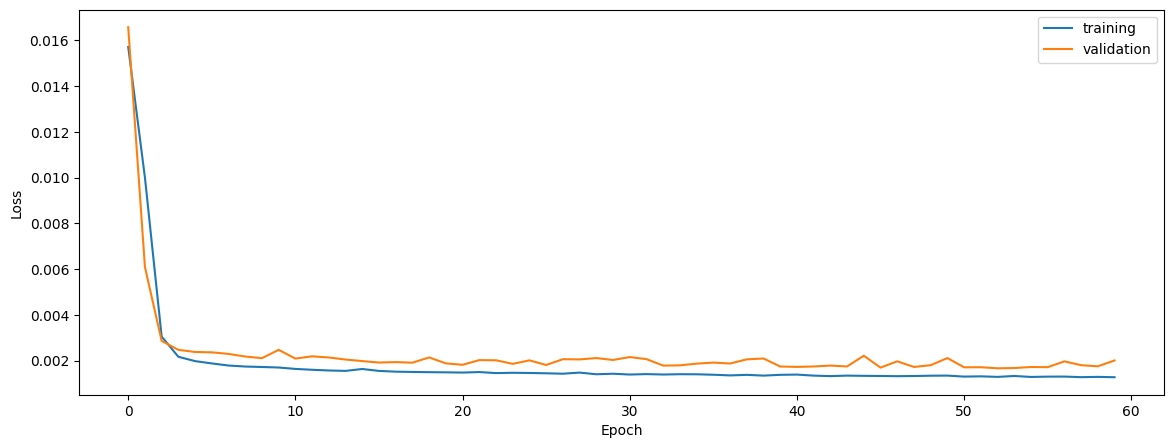

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


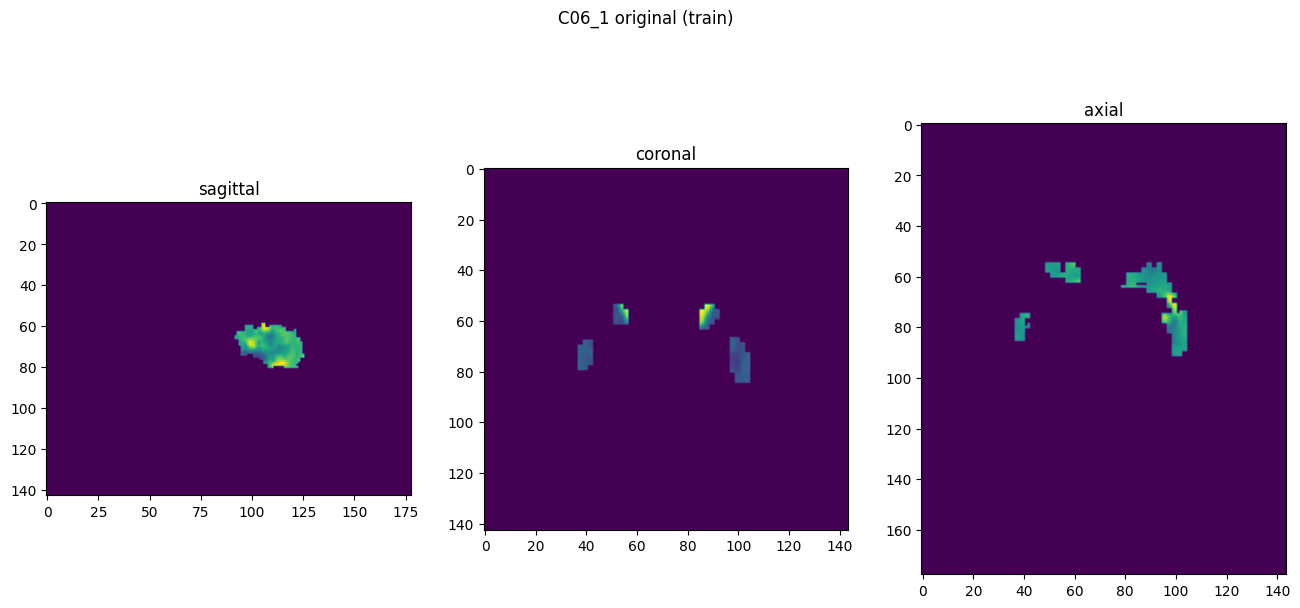

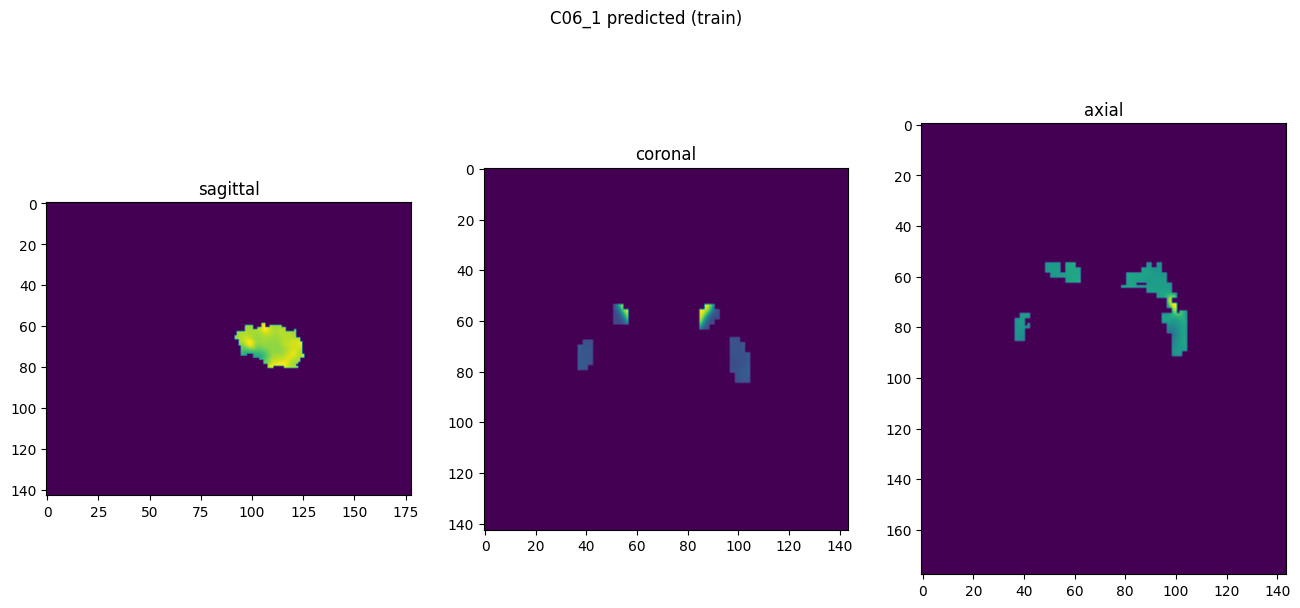

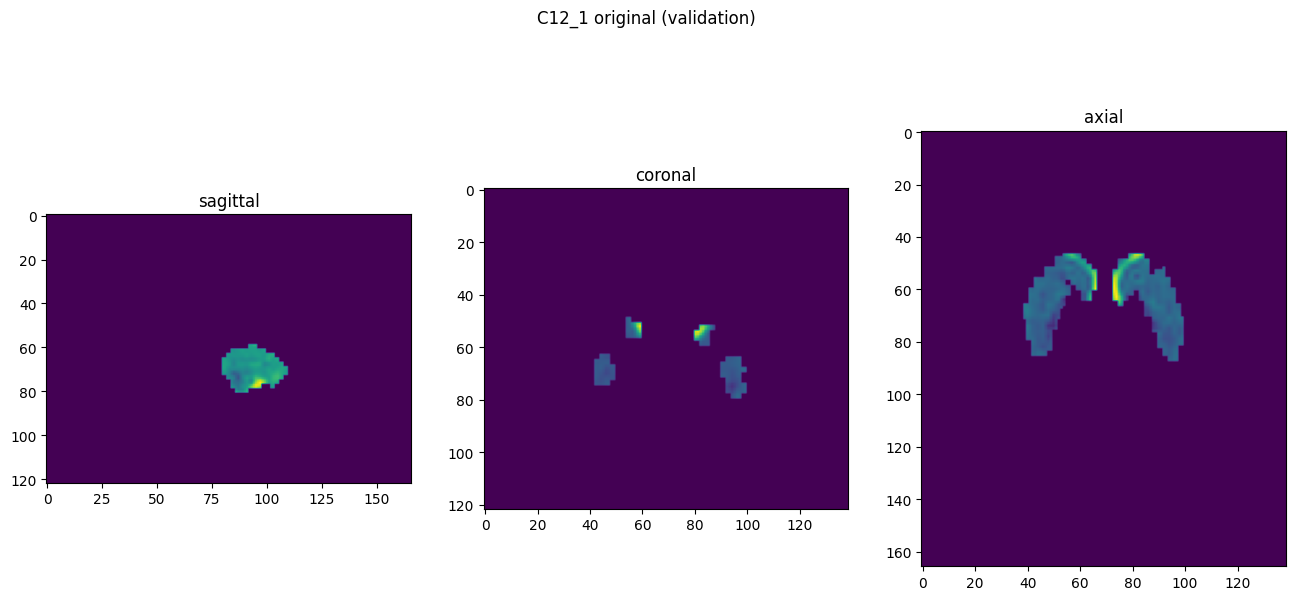

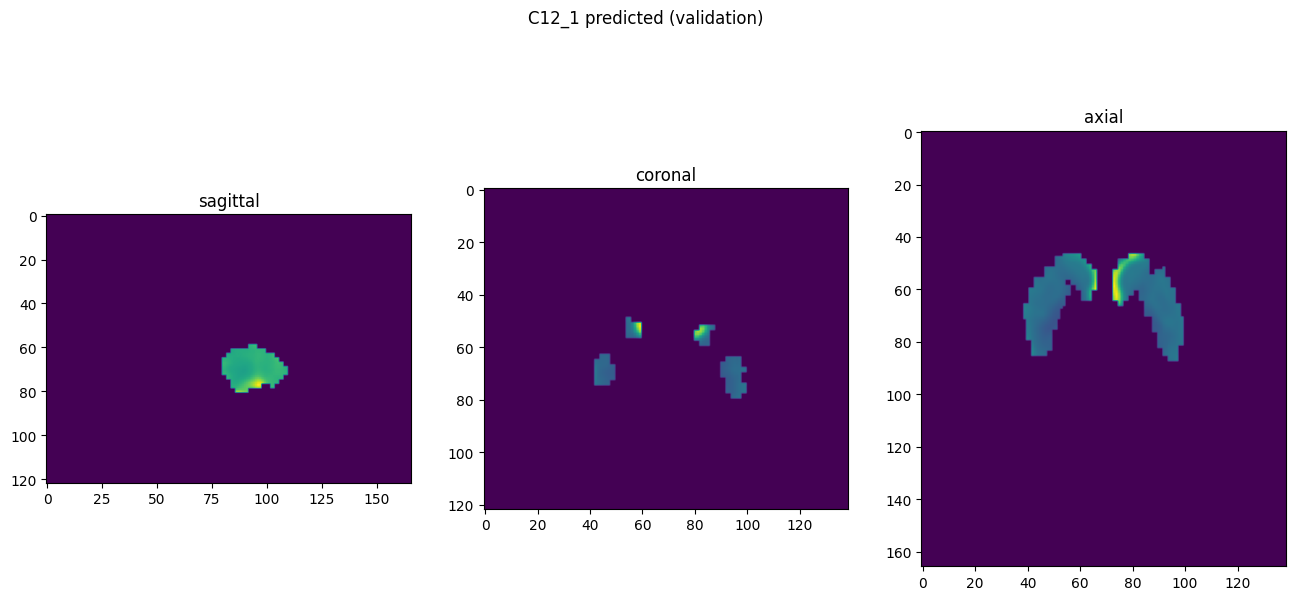

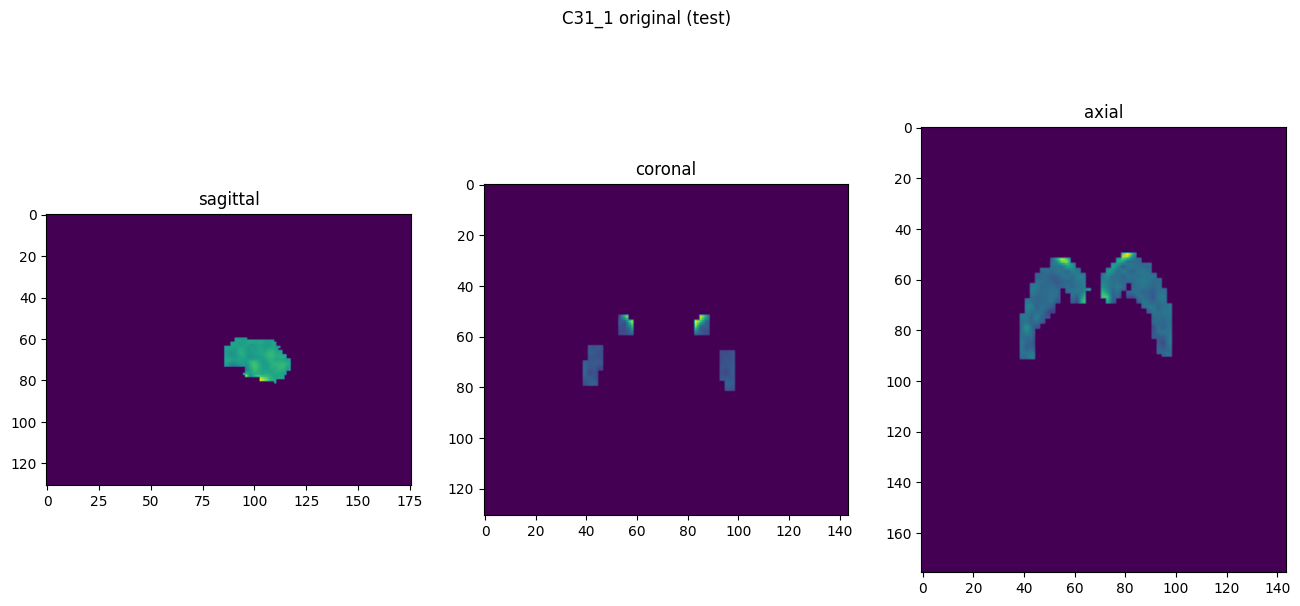

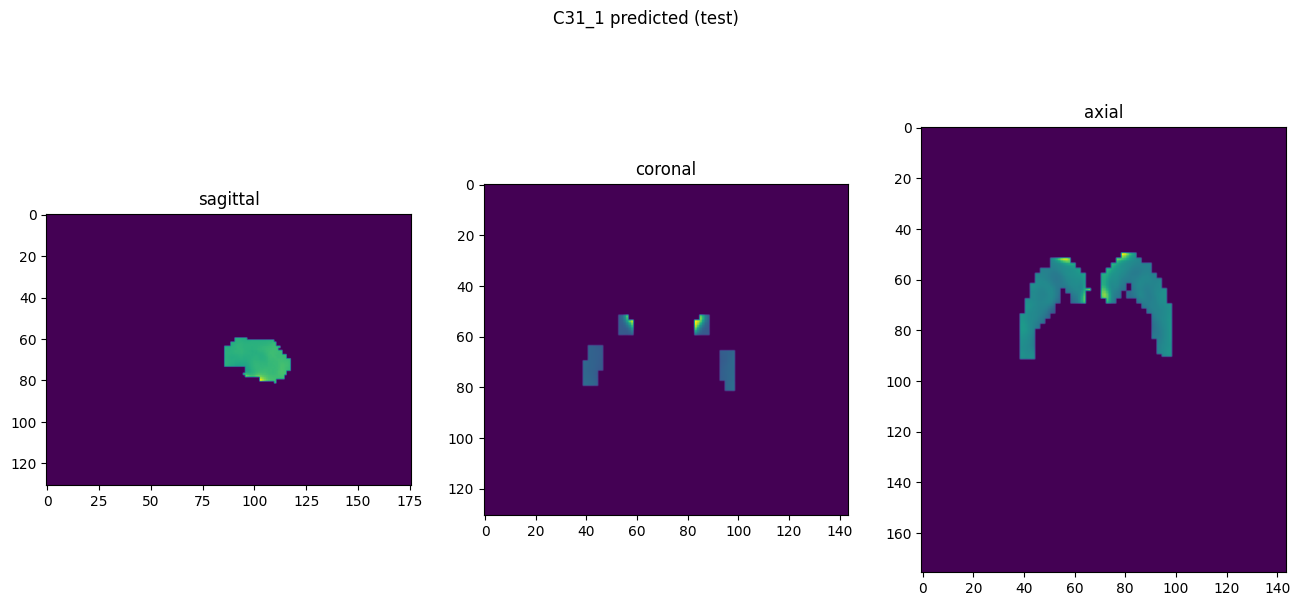

In [10]:
showResults(model, gen, threshold=None, background=False)